# Lab Assignment Two: Exploring Table Data

CS 7324

2021-03-07

Anthony Wang

## Business Understanding

[This image dataset](https://www.kaggle.com/crowww/a-large-scale-fish-dataset) is a collection of pictures taken of nine types of seafood in a Turkish supermarket. The seafood include gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, and shrimp. The dataset contains one thousand 590 px by 445 px images of of each, but this analysis will use only two hundred images of each type due to memory limitations and for the sake of computational timeliness.

[These pictures were taken specifically for feature extracdtion and species classification purposes](https://ieeexplore.ieee.org/abstract/document/9259867), and that is what this analysis will do. Such data could be used to develop machinery that could automatically sort fish using cameras. This would be useful to markets and fisheries which would need to dedicated less workers to manually sorting fish. In this use case, any classification accuracy better than randomness would be useful. Time spent correcting misclassifications would still be less than the time spent inspecting every single fish. If a model works well enough to identify live fish in their aquatic environment, biologists could use images taken in oceans and seas to estimate fish populations and do what they will with that information. Again, as long as classification accuracy is an improvement over random classification, there would be a time benefit to using such a model.

## Data Preparation

There are a total of 1800 images evenly distributed between 9 categories. Each is scaled to half of its original length and height to a resolution of 295 px by 222 px. The images are then vectorized into an array of length 196470 with preserved color channels.

Loading Black Sea Sprat images...



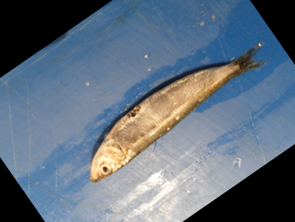

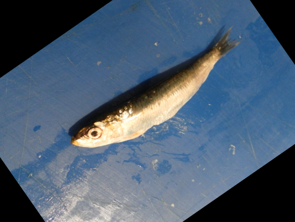



Loading Gilt-Head Bream images...



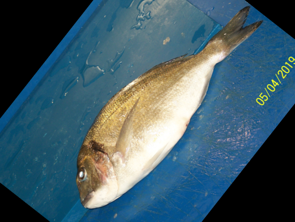

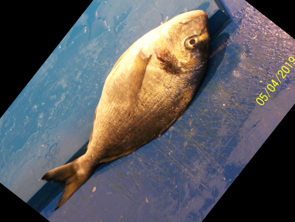



Loading Horse Mackerel images...



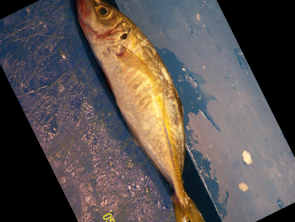

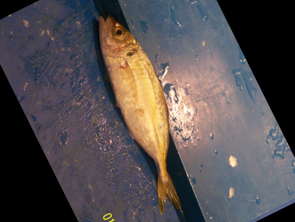



Loading Red Mullet images...



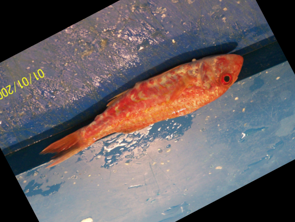

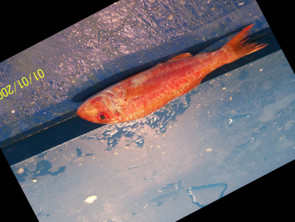



Loading Red Sea Bream images...



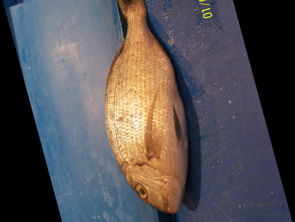

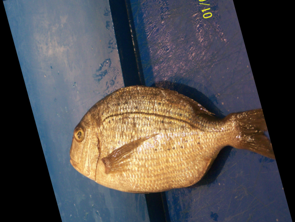



Loading Sea Bass images...



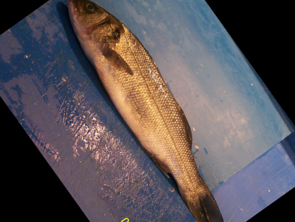

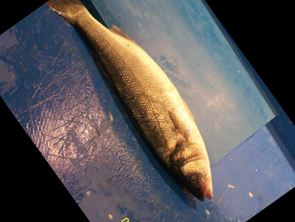



Loading Shrimp images...



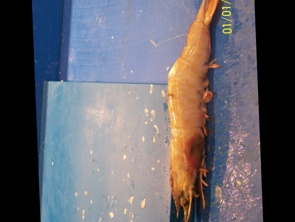

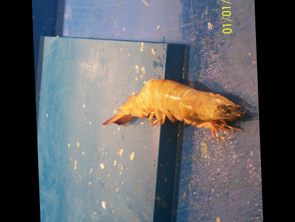



Loading Striped Red Mullet images...



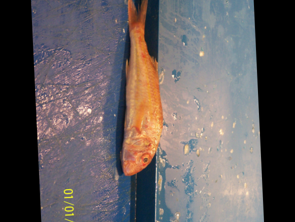

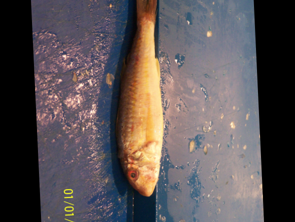



Loading Trout images...



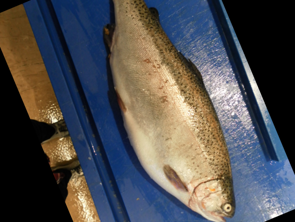

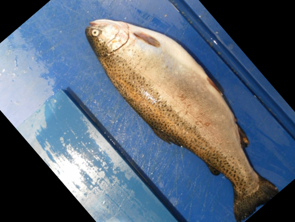

In [1]:
import numpy
from PIL import Image
import requests
from IPython.display import display

fish_types = [
    "Black Sea Sprat",
    "Gilt-Head Bream",
    "Horse Mackerel",
    "Red Mullet",
    "Red Sea Bream",
    "Sea Bass",
    "Shrimp",
    "Striped Red Mullet",
    "Trout"
]

dataset_root = "https://raw.githubusercontent.com/Djaenk/Artificial-Intelligence-Python/main/Fish_Dataset/"

data = numpy.empty((1800,196470))
target = numpy.empty((1800,), dtype='i1')
height = 222
width = 295
channels = 3

for i in range(len(fish_types)):
    print("Loading", fish_types[i], "images...\n")
    for j in range(200):
        # Load image
        url = dataset_root + fish_types[i] + "/" + str(j + 1).zfill(5) + ".png"
        image = Image.open(requests.get(url, stream = True).raw)
        image = image.resize((width, height))

        # Convert image to numpy array
        image_array = numpy.array(image) / 255

        # Vectorize image
        image_vector = image_array.ravel()

        # Append vectorized image to data matrix
        index = i * 200 + j
        data[index] = image_vector
        target[index] = i

        # Display 1st and 101st image of each type
        if j % 100 == 0:
            display(image)
            print()
    print()

In [2]:
# Visualization helper functions

from matplotlib import pyplot

def normalize(array, h, w, c):
    """Helper function reshape a numpy array into an
    image and normalize float values to between 0 - 1
    for parsing as color values"""
    img = array.reshape(h, w, c)
    img = (img - img.min()) / (img.max() - img.min())
    return img

def list_variance(pca):
    percentage = 0.05
    print("\nDimensions required to explain...")
    for d, v in enumerate(numpy.cumsum(pca.explained_variance_ratio_)):
        if v > percentage:
            print(f"{percentage * 100:.0f}% of variance: {d + 1}")
            percentage += .05
    print()

def plot_variance(**kwargs):
    pyplot.figure(figsize=(7, 7))
    for key, value in kwargs.items():
        pyplot.plot(numpy.cumsum(value.explained_variance_ratio_), label=key)
    pyplot.legend()
    pyplot.xlabel('Number of Components')
    pyplot.ylabel('Cumulative Explained Variance')
    pyplot.title('Number of Components Required to Explain Portion of Variance')
    
def plot_gallery(images, titles, height, width, channels = 3, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    pyplot.figure(figsize=(4 * n_col, 3 * n_row))
    for i in range(n_row * n_col):
        pyplot.subplot(n_row, n_col, i + 1)
        pyplot.imshow(normalize(images[i], height, width, channels), cmap=pyplot.cm.gray)
        pyplot.title(titles[i], size=12)
        pyplot.xticks(())
        pyplot.yticks(())

## Data Reduction



### Dimension Reduction Using Principle Component Analysis

Wall time: 1min 30s

Dimensions required to explain...
5% of variance: 1
10% of variance: 2
15% of variance: 3
20% of variance: 4
25% of variance: 5
30% of variance: 6
35% of variance: 7
40% of variance: 8
45% of variance: 9
50% of variance: 10
55% of variance: 11
60% of variance: 14
65% of variance: 19
70% of variance: 27
75% of variance: 40
80% of variance: 63
85% of variance: 105
90% of variance: 201



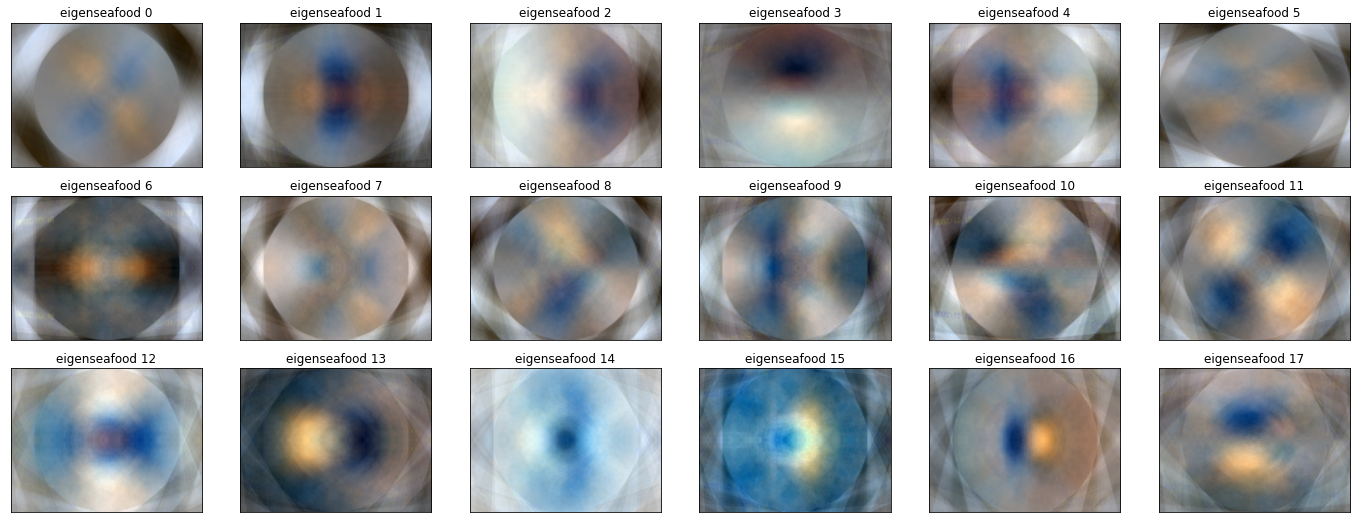

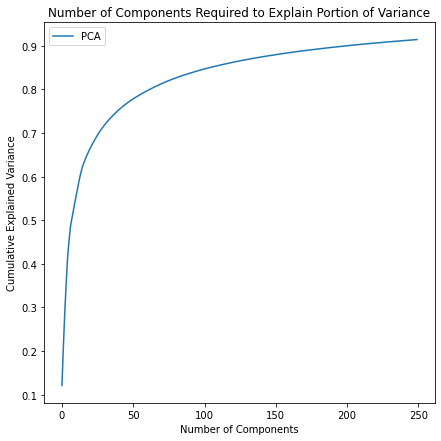

In [3]:
from sklearn.decomposition import PCA

n_components = 250
pca = PCA(n_components=n_components, svd_solver = 'full')
%time pca.fit(data.copy())

eigenseafood = pca.components_.reshape((n_components, height, width, channels))
eigenseafood_titles = ["eigenseafood %d" % i for i in range(eigenseafood.shape[0])]
plot_gallery(eigenseafood, eigenseafood_titles, height, width)
plot_variance(PCA = pca)
list_variance(pca)

Visually examining the plot of explained variance shows there is a "knee" in the curve at approximately 0.75 cumulative explained variance. After this point, the benefit of adding additional components is very small. The listed variance values support this observation to a degree. After there are sufficient components to explain three quarters of the variance, explaining an additional five percentage points of variance requires over a 50% increase in the number of components. The application of fish sorting is not very critical and can be implemented on a scope at which every cent allocated to computational resources matters. For these reasons, 40 dimensions appears to be a good bang-for-your-buck choice. 

However, it should be noted that the supposed "knee" shown in the plot can appear in a different location depending on how the axes are scaled. Compressing the x-axis relative to the y-axis would move the bend higher and vice versa. Additionally, depending on the computational and memory resources of a given application, increasing the number of components used may be worth the diminished returns on explain variance. Should one have a system capable of easily handling 500 components, there would be no need to limit oneself to just 75% explained variance with 40 components.

### Dimension Reduction Using Randomized Principle Components Analysis

Wall time: 42.9 s

Dimensions required to explain...
5% of variance: 1
10% of variance: 2
15% of variance: 3
20% of variance: 4
25% of variance: 5
30% of variance: 6
35% of variance: 7
40% of variance: 8
45% of variance: 9
50% of variance: 10
55% of variance: 11
60% of variance: 14
65% of variance: 19
70% of variance: 27
75% of variance: 40
80% of variance: 63
85% of variance: 105
90% of variance: 201



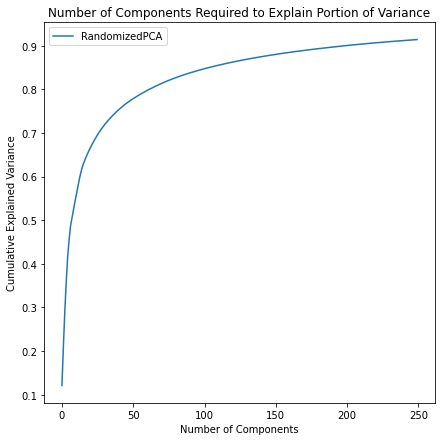

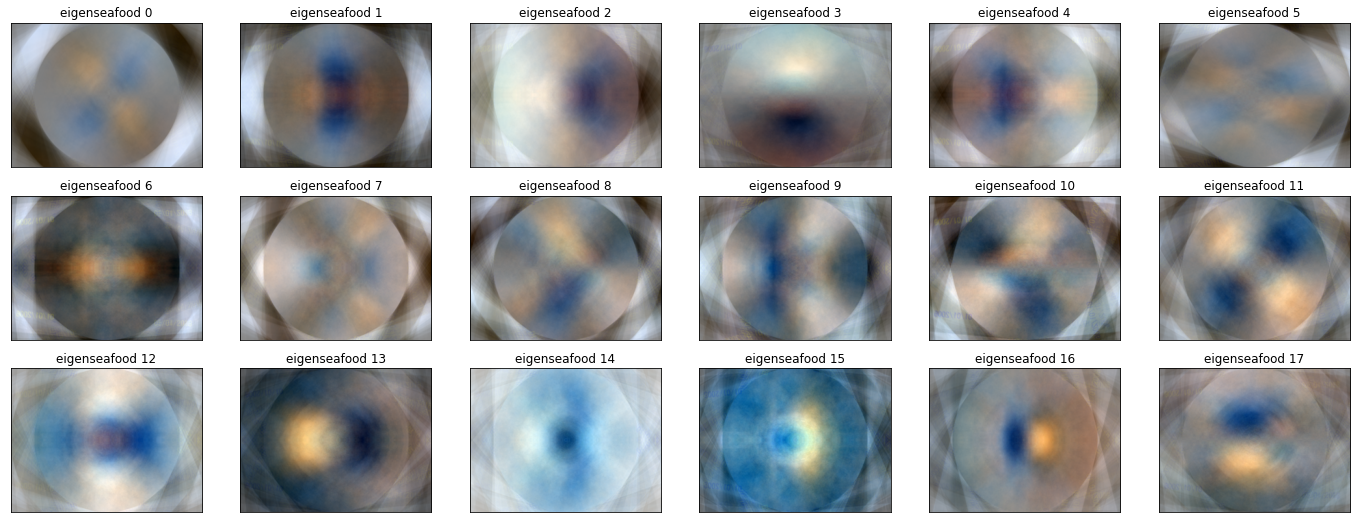

In [4]:
from sklearn.decomposition import PCA

n_components = 250
rpca = PCA(n_components=n_components, svd_solver="randomized")
%time rpca.fit(data.copy())

eigenseafood = rpca.components_.reshape((n_components, height, width, channels))
eigenseafood_titles = ["eigenseafood %d" % i for i in range(eigenseafood.shape[0])]
list_variance(rpca)
plot_variance(RandomizedPCA = rpca)
plot_gallery(eigenseafood, eigenseafood_titles, height, width)

The results of randomized PCA appear suspiciously similar to that of full PCA. Thus, the same conclusions can be drawn about 40 components being an optimal compromise between explained variance and dimensionality for the same reasons as before. Of course, if a specific percentage is imperative for a certain application, then the number of components should be increased to meet it.

### Discussion of Dimesionality Reduction Methods

To start the comparison using data already collected, the cumulative explained variance of both strategies can be plotted on top of each other.

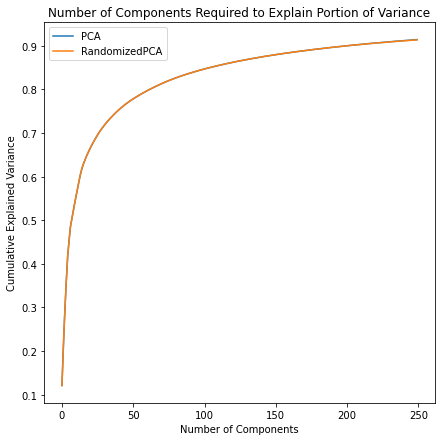

In [5]:
plot_variance(PCA = pca, RandomizedPCA = rpca)

Matching earlier suspicions, the curves perfectly match each other. To confirm, reconstruction error of both PCA methods will be conducted plotted.

<Figure size 432x288 with 0 Axes>

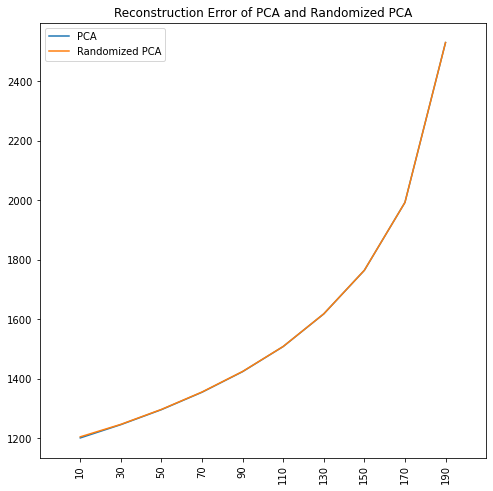

In [6]:
# Following code based on cell 5 of https://www.kaggle.com/ericlikedata/reconstruct-error-of-pca
from numpy import linalg as LA

max_comp = 200
start = 10
increment = 20
error_record_pca=[]
error_record_rpca=[]
for i in range(start, max_comp, increment):
    pca = PCA(n_components=max_comp-i, svd_solver="full")
    pca_results = pca.fit_transform(data)
    pca_proj_back = pca.inverse_transform(pca_results)
    total_loss_pca = LA.norm((data - pca_proj_back), None)
    error_record_pca.append(total_loss_pca)
for i in range(start, max_comp, increment):
    rpca = PCA(n_components=max_comp-i, svd_solver="randomized")
    rpca_results = rpca.fit_transform(data)
    rpca_proj_back = rpca.inverse_transform(rpca_results)
    total_loss_rpca = LA.norm((data - rpca_proj_back), None)
    error_record_rpca.append(total_loss_rpca)

pyplot.clf()
pyplot.figure(figsize=(8,8))
pyplot.title("Reconstruction Error of PCA and Randomized PCA")
pyplot.plot(error_record_pca, label = "PCA")
pyplot.plot(error_record_rpca, label = "Randomized PCA")
pyplot.xticks(range(len(error_record_pca)), range(start, max_comp, increment), rotation='vertical')
pyplot.xlim([-1, len(error_record_rpca)])
pyplot.legend()
pyplot.show()

Once again, the two plots are imposed on each other. Neither is more accurate at representing these seafood images with fewer components. However, accuracy is not the only aspect under consideration in an application. The randomized PCA completed in less than half of the time required for full PCA. The wall times firmly show randomized PCA should be the preferred to full PCA when performing dimensionality reduction on this dataset. In practical comparison, it vastly reduces the execution time while having zero impact on accuracy.

### Feature Extraction Using DAISY

DAISY feature extraction is performed on each color channel of every image. These features are then be appended to each other to represent every images' features with a one-dimensional array. Earlier tweaking and exploration showed that the radius of the outermost ring had the greatest impact on runtime. So, a conservative 20 pixels was chosen to keep runtimes manageable.

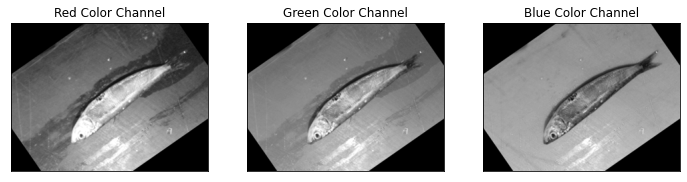

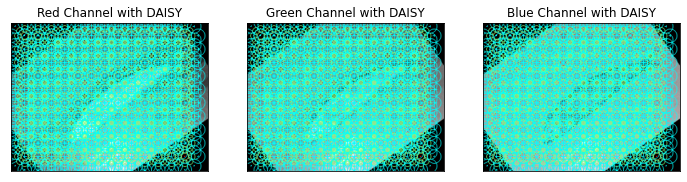

In [7]:
from skimage.feature import daisy

def run_daisy(array, height = height, width = width, visualize = False):
   return daisy(
        array.reshape(height, width),
        step = 20,
        radius = 20,
        rings = 2,
        orientations = 4,
        visualize = visualize
    )

r, g, b = numpy.dsplit(data[0].reshape((height, width, channels)), 3)

features, img_desc_r = run_daisy(r, visualize = True)
features, img_desc_g = run_daisy(g, visualize = True)
features, img_desc_b = run_daisy(b, visualize = True)

images = [r, g, b, img_desc_r, img_desc_g, img_desc_b]
titles = ["Red Color Channel", "Green Color Channel", "Blue Color Channel", "Red Channel with DAISY", "Green Channel with DAISY", "Blue Channel with DAISY"]
plot_gallery(images[:3], titles[:3], height, width, channels = 1, n_row=1, n_col=3)
plot_gallery(images[3:], titles[3:], height, width, channels = 3, n_row=1, n_col=3)

In [8]:
def extract_daisy_features(data):
    daisy_features = numpy.empty((data.shape[0], 26520))
    daisy_channels = numpy.empty((3, 10, 13, 68))
    for i in range(len(daisy_features)):
        r, g, b = numpy.dsplit(data[i].reshape(height, width, channels), 3)
        daisy_channels[0] = run_daisy(r)
        daisy_channels[1] = run_daisy(g)
        daisy_channels[2] = run_daisy(b)
        daisy_features[i] = daisy_channels.reshape((-1,))
    return daisy_features

%time daisy_features = extract_daisy_features(data)

Wall time: 4min 20s


A nearest neighbor classifier will be trained on the extracted features to help determine their usefulness.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

train_data = numpy.empty((int(len(data) * .8), 26520))
train_labels = numpy.empty((int(len(data) * .8),), dtype='i1')
test_data = numpy.empty((int(len(data) * .2), 26520))
test_labels = numpy.empty((int(len(data) * .2),), dtype='i1')
for i in range(len(fish_types)):
    for j in range(160):
        train_data[i * 160 + j] = daisy_features[i * 200 + j]
        train_labels[i * 160 + j] = i
    for j in range(40):
        test_data[i * 40 + j] = daisy_features[i * 200 + 160 +j]
        test_labels[i * 40 + j] = i

classifier = KNeighborsClassifier()
classifier.fit(train_data, train_labels)

predictions = classifier.predict(test_data)
for i in range(len(fish_types)):
    label_typed = test_labels[40*i : 40*(i+1)]
    guess_typed = predictions[40*i : 40*(i+1)]
    print(f'{fish_types[i]} Classification')
    print("Test labels:", str(label_typed).replace('\n',''))
    print("Predictions:", str(guess_typed).replace('\n',''))
    print("Accuracy:", accuracy_score(label_typed, guess_typed))
    print()
print("Overall Accuracy:", accuracy_score(test_labels, predictions))

Black Sea Sprat Classification
Test labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 0 2 2 3 3 7 7 7 7 1 1 6 6]
Accuracy: 0.6

Gilt-Head Bream Classification
Test labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy: 1.0

Horse Mackerel Classification
Test labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Predictions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 7 7 2 2 2 2 4 4 4 4 2 2 2 2 2 2 2 2 2 2]
Accuracy: 0.85

Red Mullet Classification
Test labels: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Predictions: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Accuracy: 1.0

Red Sea Bream Classification
Test labels: [4 4 4 4 4 4 4 4 4 

This initial effort shows promise with an overall accuracy of 73%. It is least surprising to see a 100% classification accuracy for shrimp, as it is a crustacean as opposed to a fish and visually the most distinct from the other seafood types. The model also achieved perfect accuracy for fourty test images of gilt-head bream and red mullet. With the exception of trout, the model also classified other seafood with accuracies which would satisfy business applications listed at the beginning of this notebook. Unfortunately, the model completely failed to correctly classify any trout. The 0% accuracy is so abysmal it's almost novel, and it seems to indicate a fundamental problem with how the model has been trained. Unfortunately, the cause for this outlier is unidentifiable to this novice data researcher. It may very well be that there isn't a problem with the clasifier or data, and this is simply what the model is capable of given its training.

The quality of the image set may contribute for the high accuracy. Each photo is centered on a well-lit side profile of the seafood with a highly contrastive background. In more practical application, images may not be as ideal and accuracy would almost certainly suffer. This could be offset by selecting a more suitable feature to extract and training the model on more images.

## Exceptional Work

### Feature Matching Using DAISY

The previously extracted features will now be used for keypoint matching. For each type of seafood, the first image will be selected as a target and the closest match to it will be selected from the remaining images. The scikit-image brute force matching function will be used to find the closest descriptor from those instances. The closeness of a match will simply be determined by the quantity of matching keypoints between the images; the image with the most matching keypoints will be considered the closest match.

In [10]:
from skimage.feature import match_descriptors
from skimage.feature import plot_matches

match_indices = []
for i in range(len(fish_types)):
    target = daisy_features[i * 200].reshape(390, 68)
    match_count = 0
    index = 0
    for j in range(1800):
        if i * 200 == j:
            continue
        match = daisy_features[j].reshape(390, 68)
        matches = match_descriptors(target, match)
        if len(matches) > match_count:
            index = j
            match_count = len(matches)
    match_indices.append(index)

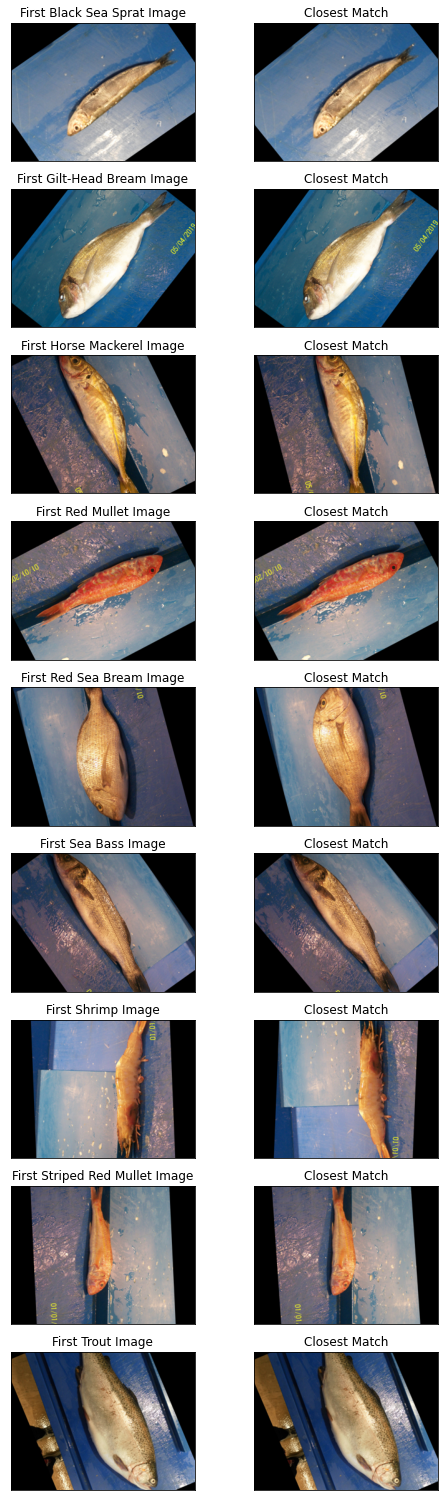

In [13]:
match_images = []
match_titles = []
for i in match_indices:
    match_images.append(data[i // 200 * 200].reshape(height, width, channels))
    match_images.append(data[i].reshape(height, width, channels))
    match_titles.append(f'First {fish_types[i // 200]} Image')
    match_titles.append(f'Closest Match')

plot_gallery(match_images, match_titles, height, width, channels = 3, n_row=9, n_col=2)

Unsurprisingly, the closest images selected from each category are almost identical to the target. With the exception of the rotated horse mackerel, reflected red sea bream, and reflected shrimp images, the other six iamges could be mistaken as being identical to the target. Again, this is likely partially attributable to the quality and consistency of the image dataset, but visual inspection of these results would indicate image matching using DAISY keypoint matching is a successful endeavor.